In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import entropy
import numpy as np
import altair as alt 
import plotly.graph_objects as go
import seaborn as sns
import networkx as nx

In [3]:
# load in data from our 3 California national Parks 
df_redwood = pd.read_excel("redwood.xlsx")
df_joshua = pd.read_excel("joshua.xlsx")
df_sequoia = pd.read_excel("sequoia.xlsx")

# combine them into one dataframe
df_combined = pd.concat([df_redwood, df_joshua, df_sequoia], ignore_index=True)
df_combined.shape

(10661, 33)

In [4]:
# look at missing values by column
df_combined.isnull().sum()

Region                 10661
Park Code                  0
Park Name                  0
Category                   0
Category Sort              0
Order                    500
Family                   504
Taxon Code                 0
TSN                       47
Taxon Record Status        0
Scientific Name            0
Common Names            4166
Synonyms                9954
Park Accepted              0
Sens?                      0
Record Status              0
Occurrence              5315
Occurrence Tags        10563
Nativeness              5324
Nativeness Tags        10651
Abundance               6376
NPS Tags                9255
Park Tags              10636
Internal Park Tags     10661
References               678
Observations            9455
Vouchers                7034
ExternalLinks          10661
T&E                     9814
State Status           10463
Ozone                  10614
GRank                   4809
SRank                   6005
dtype: int64

In [5]:
# drop columns with large amount of missing values
df_combined = df_combined.drop(['Region', 'Internal Park Tags', 'ExternalLinks', 'Ozone', 'Park Tags', 'Nativeness Tags', 'Occurrence Tags'], axis=1)
df_combined.shape

(10661, 26)

In [6]:
# drop species not in park or unconfirmed
df_combined = df_combined[~df_combined['Occurrence'].isin(['Not In Park', 'Unconfirmed'])]
df_combined.shape

(10070, 26)

In [7]:
# drop species with no family/order name
df_combined = df_combined[~df_combined['Order'].isnull()]
df_combined = df_combined[~df_combined['Family'].isnull()]
df_combined = df_combined[df_combined['Record Status'].isin(['Approved'])]

# Filter out rows with more than two words in the 'Scientific Name' column
df_combined = df_combined[df_combined['Scientific Name'].str.split().str.len() == 2]

# Split the 'Scientific Name' column into 'Genus' and 'Species'
df_combined[['Genus', 'Species']] = df_combined['Scientific Name'].str.split(' ', expand=True)

# get just non-native yet abundant species
non_native_common = df_combined[(df_combined['Nativeness'] == 'Non-native') & 
                                (df_combined['Abundance'].isin(['Abundant', 'Common']))]


In [8]:
import plotly.graph_objects as go
import pandas as pd

# Step 1: Get the counts for order -> family
category_order_count = non_native_common.groupby(['Category', 'Order']).size().reset_index(name='count')

# Step 2: Get the counts for family -> genus
order_park_count = non_native_common.groupby(['Order', 'Park Name']).size().reset_index(name='count')

# Combine the order -> family and family -> genus into one list of source, target, and value for Sankey
# For order -> family
order_family_links = category_order_count[['Category', 'Order', 'count']].rename(columns={'Category': 'source', 'Order': 'target', 'count': 'value'})

# For family -> genus
family_genus_links = order_park_count[['Order', 'Park Name', 'count']].rename(columns={'Order': 'source', 'Park Name': 'target', 'count': 'value'})

# Concatenate the two link DataFrames
links = pd.concat([order_family_links, family_genus_links], ignore_index=True)

# Create a list of nodes
nodes = list(pd.concat([category_order_count['Category'], category_order_count['Order'], order_park_count['Park Name']]).unique())

# Map the nodes to indices
nodes_dict = {node: i for i, node in enumerate(nodes)}

# Add node indices to the links
links['source'] = links['source'].map(nodes_dict)
links['target'] = links['target'].map(nodes_dict)

# Create a color map for nodes
order_color = '#9ecae1'
family_color = '#4292c6'
genus_color = '#08519c'

# Assign colors to nodes
node_colors = []
for node in nodes:
    if node in category_order_count['Category'].values:
        node_colors.append(order_color)
    elif node in order_park_count['Order'].values:
        node_colors.append(family_color)
    else:
        node_colors.append(genus_color)

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color=node_colors 
    ),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['value']
    )
))

# Add labels for the columns
fig.add_annotation(
    x=0.02,  # Adjust this value to position above "Category" column
    y=1.1,  # Slightly above the top of the graph
    text="Category",
    showarrow=False,
    font=dict(size=16, color="black")
)

fig.add_annotation(
    x=0.5,  # Adjust this value to position above "Order" column
    y=1.1,
    text="Order",
    showarrow=False,
    font=dict(size=16, color="black")
)

fig.add_annotation(
    x=0.98,  # Adjust this value to position above "Park Name" column
    y=1.1,
    text="Park Name",
    showarrow=False,
    font=dict(size=16, color="black")
)

# Update layout
fig.update_layout(title_text="Non-Native Abundant Species", font_size=16, height=550)
fig.show()
fig.write_html("sankey.html")


In [8]:
#top_orders = df_combined[(df_combined['Park Code'] == 'REDW')]

# Step 1: Get the counts for order -> family
order_family_count = df_combined.groupby(['Order', 'Family']).size().reset_index(name='count')

# Step 2: Get the counts for family -> genus
family_genus_count = df_combined.groupby(['Family', 'Genus']).size().reset_index(name='count')

# Combine the order -> family and family -> genus into one list of source, target, and value for Sankey
# For order -> family
order_family_links = order_family_count[['Order', 'Family', 'count']].rename(columns={'Order': 'source', 'Family': 'target', 'count': 'value'})

# For family -> genus
family_genus_links = family_genus_count[['Family', 'Genus', 'count']].rename(columns={'Family': 'source', 'Genus': 'target', 'count': 'value'})

# Concatenate the two link DataFrames
links = pd.concat([order_family_links, family_genus_links], ignore_index=True)

# Create a list of nodes
nodes = list(pd.concat([order_family_count['Order'], order_family_count['Family'], family_genus_count['Genus']]).unique())

# Map the nodes to indices
nodes_dict = {node: i for i, node in enumerate(nodes)}

# Add node indices to the links
links['source'] = links['source'].map(nodes_dict)
links['target'] = links['target'].map(nodes_dict)

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes
    ),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['value']
    )
))

fig.update_layout(title_text="all", font_size=14, height=800)
fig.show()

In [9]:
import pandas as pd
import plotly.graph_objects as go

# Step 1: Get the counts for category -> order
category_order_count = df_combined.groupby(['Category', 'Order']).size().reset_index(name='count')

# Step 2: Get the counts for order -> family
order_family_count = df_combined.groupby(['Order', 'Family']).size().reset_index(name='count')

# Step 3: Get the counts for family -> genus
family_genus_count = df_combined.groupby(['Family', 'Genus']).size().reset_index(name='count')

# Step 4: Get the counts for genus -> species
genus_species_count = df_combined.groupby(['Genus', 'Species']).size().reset_index(name='count')

# Step 5: For each category, get the top 5 orders
filtered_category_order_count = (
    category_order_count.assign(rank=category_order_count.groupby('Category')['count'].rank(method='first', ascending=False))
    .query('rank <= 1')
    .drop(columns='rank')
)

# Step 6: For each order, get the top 5 families
filtered_order_family_count = (
    order_family_count[order_family_count['Order'].isin(filtered_category_order_count['Order'])]
    .assign(rank=order_family_count.groupby('Order')['count'].rank(method='first', ascending=False))
    .query('rank <= 1')
    .drop(columns='rank')
)

# Step 7: For each family, get the top 1 genus
filtered_family_genus_count = (
    family_genus_count[family_genus_count['Family'].isin(filtered_order_family_count['Family'])]
    .assign(rank=family_genus_count.groupby('Family')['count'].rank(method='first', ascending=False))
    .query('rank <= 1')
    .drop(columns='rank')
)

# Step 8: For each genus, get the top 1 species
filtered_genus_species_count = (
    genus_species_count[genus_species_count['Genus'].isin(filtered_family_genus_count['Genus'])]
    .assign(rank=genus_species_count.groupby('Genus')['count'].rank(method='first', ascending=False))
    .query('rank <= 1')
    .drop(columns='rank')
)

# Combine the links for each level
# Category -> Order
category_order_links = filtered_category_order_count[['Category', 'Order', 'count']].rename(
    columns={'Category': 'source', 'Order': 'target', 'count': 'value'}
)

# Order -> Family
order_family_links = filtered_order_family_count[['Order', 'Family', 'count']].rename(
    columns={'Order': 'source', 'Family': 'target', 'count': 'value'}
)

# Family -> Genus
family_genus_links = filtered_family_genus_count[['Family', 'Genus', 'count']].rename(
    columns={'Family': 'source', 'Genus': 'target', 'count': 'value'}
)

# Genus -> Species
genus_species_links = filtered_genus_species_count[['Genus', 'Species', 'count']].rename(
    columns={'Genus': 'source', 'Species': 'target', 'count': 'value'}
)

# Concatenate all the links
links = pd.concat([category_order_links, order_family_links, family_genus_links, genus_species_links], ignore_index=True)

# Create a list of nodes
nodes = list(pd.concat([
    filtered_category_order_count['Category'],
    filtered_category_order_count['Order'],
    filtered_order_family_count['Family'],
    filtered_family_genus_count['Genus'],
    filtered_genus_species_count['Species']
]).unique())

# Map the nodes to indices
nodes_dict = {node: i for i, node in enumerate(nodes)}

# Add node indices to the links
links['source'] = links['source'].map(nodes_dict)
links['target'] = links['target'].map(nodes_dict)

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes
    ),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['value']
    )
))

fig.show()


In [29]:
import pandas as pd
import plotly.graph_objects as go

# Step 1: Get the counts for category -> species
category_species_count = df_combined.groupby(['Category', 'Scientific Name']).size().reset_index(name='count')

# Step 2: For each category, get the top 5 species
filtered_category_species_count = (
    category_species_count.assign(rank=category_species_count.groupby('Category')['count'].rank(method='first', ascending=False))
    .query('rank <= 5')  # Select the top 5 species per category
    .drop(columns='rank')
)

# Create the links for category -> species
category_species_links = filtered_category_species_count[['Category', 'Scientific Name', 'count']].rename(
    columns={'Category': 'source', 'Scientific Name': 'target', 'count': 'value'}
)

# Create a list of nodes
nodes = list(pd.concat([
    filtered_category_species_count['Category'],
    filtered_category_species_count['Scientific Name']
]).unique())

# Map the nodes to indices
nodes_dict = {node: i for i, node in enumerate(nodes)}

# Add node indices to the links
category_species_links['source'] = category_species_links['source'].map(nodes_dict)
category_species_links['target'] = category_species_links['target'].map(nodes_dict)

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes
    ),
    link=dict(
        source=category_species_links['source'],
        target=category_species_links['target'],
        value=category_species_links['value']
    )
))

fig.show()


In [54]:
# Assign weights to abundance categories
abundance_weights = {
    'Unknown': 0,  
    'Rare': 2,
    'Uncommon': 4,
    'Occasional': 6,
    'Common': 8,
    'Abundant': 10
}

# Map the abundance categories to weights
df_combined['Abundance Weight'] = df_combined['Abundance'].map(abundance_weights)

# Function to calculate Shannon Index for each park
def calculate_shannon_index(df):
    # Group by Park Code and calculate total abundance per park
    park_abundance = df.groupby('Park Name')['Abundance Weight'].sum()
    
    # Calculate relative abundance (p_i) for each species in each park
    df['Relative Abundance'] = df['Abundance Weight'] / df.groupby('Park Code')['Abundance Weight'].transform('sum')
    
    # Shannon Index formula: H' = -sum(p_i * ln(p_i))
    df['Shannon Component'] = df['Relative Abundance'] * np.log(df['Relative Abundance'])
    
    # Calculate Shannon Index per park by summing the components and negating the result
    shannon_index = df.groupby('Park Name')['Shannon Component'].sum() * -1
    
    return shannon_index

# Calculate the Shannon Diversity Index for each park
shannon_index_per_park = calculate_shannon_index(df_combined)

# Output the results
print(shannon_index_per_park)

Park Name
Joshua Tree National Park                  6.457485
Redwood National Park                      6.636249
Sequoia and Kings Canyon National Parks    7.132308
Name: Shannon Component, dtype: float64


/Applications/anaconda3/envs/ds4420/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log



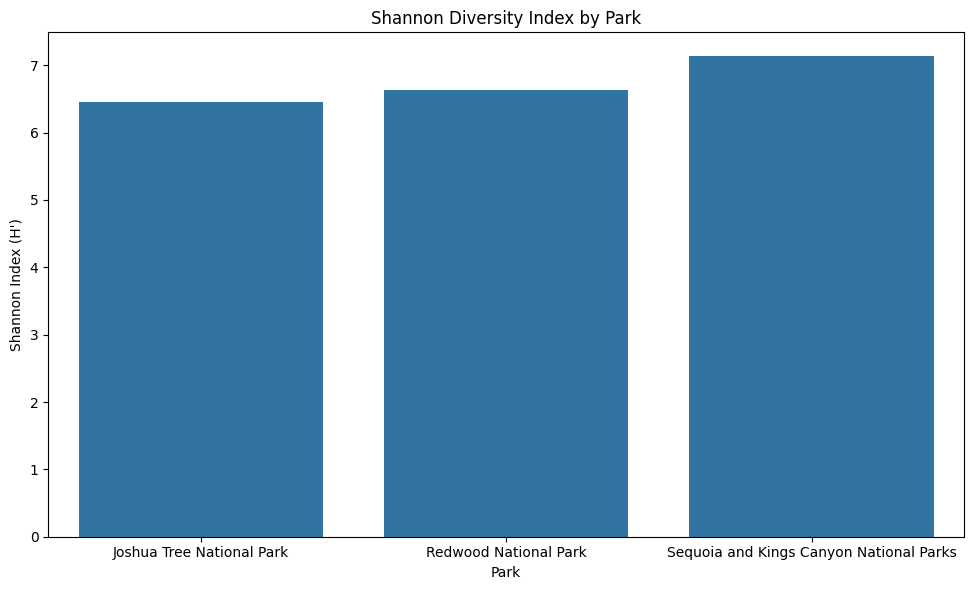

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the Shannon Diversity Index for each park
plt.figure(figsize=(10, 6))
sns.barplot(x=shannon_index_per_park.index, y=shannon_index_per_park.values)
plt.title('Shannon Diversity Index by Park')
plt.xlabel('Park')
plt.ylabel('Shannon Index (H\')')
plt.tight_layout()
plt.show()


In [69]:
import pandas as pd
import plotly.graph_objects as go

# Step 1: Get the counts for category -> order
category_order_count = df_combined.groupby(['Category', 'Order']).size().reset_index(name='count')

# Step 2: Get the counts for order -> family
order_family_count = df_combined.groupby(['Order', 'Family']).size().reset_index(name='count')

# Step 3: Get the counts for family -> genus
family_genus_count = df_combined.groupby(['Family', 'Genus']).size().reset_index(name='count')

# Step 4: Get the counts for genus -> species
genus_species_count = df_combined.groupby(['Genus', 'Species']).size().reset_index(name='count')

# Step 5: For each category, get the top 5 orders
filtered_category_order_count = (
    category_order_count.assign(rank=category_order_count.groupby('Category')['count'].rank(method='first', ascending=False))
    .query('rank <= 1')
    .drop(columns='rank')
)

# Step 6: For each order, get the top 5 families
filtered_order_family_count = (
    order_family_count[order_family_count['Order'].isin(filtered_category_order_count['Order'])]
    .assign(rank=order_family_count.groupby('Order')['count'].rank(method='first', ascending=False))
    .query('rank <= 1')
    .drop(columns='rank')
)

# Step 7: For each family, get the top 1 genus
filtered_family_genus_count = (
    family_genus_count[family_genus_count['Family'].isin(filtered_order_family_count['Family'])]
    .assign(rank=family_genus_count.groupby('Family')['count'].rank(method='first', ascending=False))
    .query('rank <= 1')
    .drop(columns='rank')
)

# Step 8: For each genus, get the top 1 species
filtered_genus_species_count = (
    genus_species_count[genus_species_count['Genus'].isin(filtered_family_genus_count['Genus'])]
    .assign(rank=genus_species_count.groupby('Genus')['count'].rank(method='first', ascending=False))
    .query('rank <= 1')
    .drop(columns='rank')
)

# Step 9: Find the most frequent species for each family based on "References"
# We assume 'Scientific Name' is a combination of 'Genus' and 'Species'
df_combined['Scientific Name'] = df_combined['Genus'] + ' ' + df_combined['Species']

# Get the most frequent Scientific Name for each Family
family_scientific_name = df_combined.groupby('Family')['Scientific Name'].agg(lambda x: x.mode()[0]).reset_index()

# Step 10: Merge this information with the family genus count to replace Species with Scientific Name
filtered_family_genus_count = pd.merge(filtered_family_genus_count, family_scientific_name, on='Family', how='left')

# Combine the links for each level
# Category -> Order
category_order_links = filtered_category_order_count[['Category', 'Order', 'count']].rename(
    columns={'Category': 'source', 'Order': 'target', 'count': 'value'}
)

# Order -> Family
order_family_links = filtered_order_family_count[['Order', 'Family', 'count']].rename(
    columns={'Order': 'source', 'Family': 'target', 'count': 'value'}
)

# Family -> Scientific Name (instead of Genus -> Species)
family_scientific_name_links = filtered_family_genus_count[['Family', 'Scientific Name', 'count']].rename(
    columns={'Family': 'source', 'Scientific Name': 'target', 'count': 'value'}
)

# Concatenate all the links
links = pd.concat([category_order_links, order_family_links, family_scientific_name_links], ignore_index=True)

# Create a list of nodes
nodes = list(pd.concat([
    filtered_category_order_count['Category'],
    filtered_category_order_count['Order'],
    filtered_order_family_count['Family'],
    filtered_family_genus_count['Scientific Name']  # Add Scientific Name instead of Genus and Species
]).unique())

# Map the nodes to indices
nodes_dict = {node: i for i, node in enumerate(nodes)}

# Add node indices to the links
links['source'] = links['source'].map(nodes_dict)
links['target'] = links['target'].map(nodes_dict)

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes
    ),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['value']
    )
))

fig.show()
